## Libraries

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import histogram
import os
os.makedirs('./plot', exist_ok=True)

## Import dataset

In [97]:
# Importing ISBG as dataframe
ISBG = pd.read_excel("./data/ISBSG-whole.xlsx",header=3)
# ISBG.set_index("Project ID", inplace=True)

## Head (before any transformation)

In [98]:
ISBG.head()

,ISBSG Project ID,Data Quality Rating,UFP rating,Year of Project,Industry Sector,Organisation Type,Application Group,Application Type,Development Type,Development Platform,...,Added count,Changed count,Deleted count,COSMIC Entry,COSMIC Exit,COSMIC Read,COSMIC Write,Lines of Code,Lines of Code not Statements,Other Size Units
0,10001,D,A,1998,Service Industry,Recreation & Personnel Services;,Business Application,Transaction/Production System;,New Development,MR,...,237.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10011,B,A,1996,Construction,Construction;,Business Application,Stock control & order processing;,New Development,Multi,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10012,B,A,2002,Wholesale & Retail,Billing;,Business Application,Billing;,Enhancement,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10014,B,A,2004,NaN,NaN,NaN,NaN,Enhancement,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10015,B,A,2000,Wholesale & Retail,Wholesale & Retail Trade;,Business Application,Management Information System;,Enhancement,MF,...,35.0,347.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Extract columns

In [99]:
cols_needed = ['Max Team Size','COSMIC Read','COSMIC Write','COSMIC Entry','COSMIC Exit','Functional Size','Project Elapsed Time','Development Platform','Primary Programming Language','Summary Work Effort']
ISBG_interest = ISBG[cols_needed]
ISBG_interest.head()

,Max Team Size,COSMIC Read,COSMIC Write,COSMIC Entry,COSMIC Exit,Functional Size,Project Elapsed Time,Development Platform,Primary Programming Language,Summary Work Effort
0,5.0,NaN,NaN,NaN,NaN,237.0,6.0,MR,Oracle,1850.0
1,NaN,NaN,NaN,NaN,NaN,443.0,2.6,Multi,Access,796.0
2,NaN,NaN,NaN,NaN,NaN,76.0,NaN,NaN,COBOL,1100.0
3,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,28.0
4,NaN,NaN,NaN,NaN,NaN,382.0,3.0,MF,COBOL,22000.0


## Remove missing COSMIC rows

254


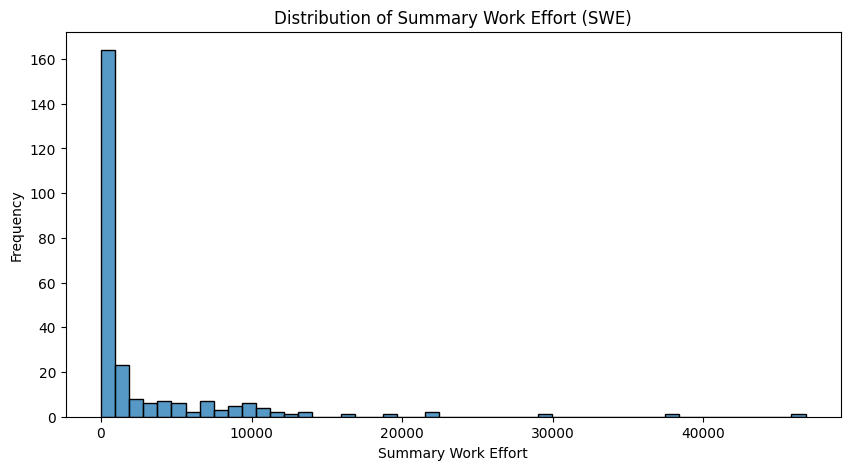

In [100]:
df_clean = ISBG_interest.dropna(subset=["COSMIC Read", "COSMIC Write", "COSMIC Exit", "COSMIC Entry"])
print(len(df_clean))
plt.figure(figsize=(10,5))
sns.histplot(df_clean['Summary Work Effort'], kde=False, bins=50)  # Set bins and kde to False

plt.title('Distribution of Summary Work Effort (SWE)')
plt.xlabel('Summary Work Effort')
plt.ylabel('Frequency')
plt.savefig('./plot/dfCleanhistogram.svg')
plt.show()

df_clean = df_clean.dropna(subset=['Summary Work Effort'])


## One-hot encoding + Train-test split (80-20)

In [101]:
from sklearn.model_selection import train_test_split

df_clean = pd.get_dummies(df_clean)
X_clean = df_clean.drop(columns=["Summary Work Effort"])
y_clean = df_clean["Summary Work Effort"]
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)


## KNN imputation to Training data

In [102]:
import pandas as pd
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

# Fit the imputer on the training data and transform both train and test sets
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)  # Apply the same transformation to the test set


## Scaling numerical variables (NOT O-H enc) in the Training Set

In [103]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_imputed)
X_test = scaler.transform(X_test_imputed)


## Log transform SWE

In [104]:
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)



# TRAINING <3

## Baseline - Decision Tree

In [145]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Define model
dt = DecisionTreeRegressor(random_state=42)

# Define scoring metrics (on log scale)
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error),
    'mse': make_scorer(mean_squared_error),
}

# Run 5-fold cross-validation
cv_results = cross_validate(
    dt,
    X_train,
    y_train,  # log-transformed SWE
    cv=10,
    scoring=scoring,
    return_train_score=False
)

# Show average scores
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")



R2 (mean ± std): 0.5168 ± 0.2182
MAE (mean ± std): 0.9580 ± 0.1407
MSE (mean ± std): 1.8604 ± 0.7171


## ANN

In [141]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the ANN model using MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=100, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Make predictions
y_pred = mlp.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"R2: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


R2: 0.4861585253761862
MAE: 1.2718073116767725
MSE: 2.5450506063862206
RMSE: 1.5953214743073638


c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


## XGBoost

In [144]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                          colsample_bytree=0.3, 
                          learning_rate=0.1, 
                          max_depth=5, 
                          alpha=10, 
                          n_estimators=100, 
                          random_state=42)

# Train the model
xg_reg.fit(X_train, y_train)

# Make predictions
y_pred = xg_reg.predict(X_test)

# Calculate performance metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"R²: {r2}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


R²: 0.8109120070741871
MAE: 0.735403711049847
MSE: 0.9365505410175595
RMSE: 0.9677554138404805
